In [3]:
import numpy as np
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor,transforms


import matplotlib.pyplot as plt

In [18]:
#importing the dataset
train_data=datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
                                    transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
    target_transform=None
)

test_data=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
                                    transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = (0.1307,), std = (0.3081,))])
)

In [19]:
image,label=train_data[0]
image.shape #colo_channels=1,height,width

torch.Size([1, 32, 32])

In [20]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [21]:
len(train_data.data),len(train_data.targets),len(test_data.data),len(test_data.targets)

(60000, 60000, 10000, 10000)

Image shape: torch.Size([1, 32, 32])


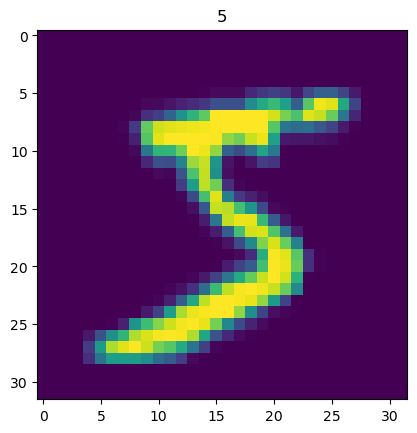

In [22]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) #[color_channels,height,width]
plt.title(label);

In [10]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader=DataLoader(test_data,
                           batch_size=BATCH_SIZE,
                           shuffle=False

)
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")



Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x14ce314f0>, <torch.utils.data.dataloader.DataLoader object at 0x14ce31af0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [25]:
device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [15]:
class LeNet5ModelV1(nn.Module):
    """Model architecture"""

    def __init__(self,input_shape:int,output_shape:int):
        super().__init__()
        self.layer_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=6,kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )
        self.layer_2=nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fc1=nn.Linear(in_features=400,out_features=120)
        self.relu1=nn.ReLU()
        self.fc2=nn.Linear(in_features=120,out_features=84)
        self.relu2=nn.ReLU()

        self.output=nn.Linear(84,out_features=output_shape)
    
    def forward(self,x):
        
        out=self.layer_2(self.layer_1(x))
        #flatten the layer before fc1
        out = out.view(out.size(0), -1)
        out=self.output(self.relu2(self.fc2(self.relu1(self.fc1(out)))))

        return out


In [23]:
model=LeNet5ModelV1(input_shape=1,output_shape=10).to(device)

#loss
loss_fn=nn.CrossEntropyLoss()

#optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions."""

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [26]:

torch.manual_seed(42)

epochs=10

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch,(X,y) in enumerate(train_dataloader):
        #convert the data from cpu to target-device
        X, y = X.to(device), y.to(device)
        ###Training
        model.train()
        #1.forward pass
        y_pred=model(X)
        #2.calculate the loss
        loss=loss_fn(y_pred,y)
        train_loss+=loss
        #3.optimizer zero_grad
        optimizer.zero_grad()
        #4.backprop
        loss.backward()
        #5.optimizer step
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0 
    ###Testing
    model.eval()
    ##with torch no_grad
    with torch.inference_mode():
        for X, y in test_dataloader:
            #target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")



Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.25048 | Test loss: 0.17712, Test acc: 95.35%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.16451 | Test loss: 0.15797, Test acc: 96.12%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.14475 | Test loss: 0.12888, Test acc: 97.20%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.13139 | Test loss: 0.14260, Test acc: 96.99%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
L

In [83]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""

    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            #target device
            X, y = X.to(device), y.to(device)
            #forward pass
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'LeNet5ModelV1',
 'model_loss': 0.11280898004770279,
 'model_acc': 97.85343450479233}